In [1]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
import jieba
import numpy as np
from sklearn.impute import SimpleImputer

# 1 特征中含有字符串的时候（当成类别），如何做特征提取

In [2]:
def dictvec():
    """
    字典数据提取
    :return: None
    """
    # 实例化
    # sparse改为True，输出的是每个不为零位置的坐标，稀疏矩阵可以节省存储空间
    # 矩阵中存在大量的0，sparse存储只记录非零位置，节省空间的作用
    #Vectorizer中文含义是矢量器的含义
    dict1 = DictVectorizer(sparse=True)  # 把sparse设置为True，输出的是稀疏矩阵
    # 每个样本是一个字典，字典的key是特征名，value是特征值，有三个样本
    #调用fit_transform方法，把字典转换为稀疏矩阵
    data = dict1.fit_transform([{'city': '北京', 'temperature': 100},
                                {'city': '上海', 'temperature': 60},
                                {'city': '深圳', 'temperature': 30}])
    print(data)
    print('-' * 50)
    # 字典中一些类别数据，分别进行转换成特征
    print(dict1.get_feature_names_out())
    print("-" * 50)
    print(dict1.inverse_transform(data))  # 去看每个特征代表的含义，逆转回去

    return None


dictvec()

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 6 stored elements and shape (3, 4)>
  Coords	Values
  (0, 1)	1.0
  (0, 3)	100.0
  (1, 0)	1.0
  (1, 3)	60.0
  (2, 2)	1.0
  (2, 3)	30.0
--------------------------------------------------
['city=上海' 'city=北京' 'city=深圳' 'temperature']
--------------------------------------------------
[{'city=北京': np.float64(1.0), 'temperature': np.float64(100.0)}, {'city=上海': np.float64(1.0), 'temperature': np.float64(60.0)}, {'city=深圳': np.float64(1.0), 'temperature': np.float64(30.0)}]


## 1.2 一段英文文本如何变为数值类型

In [3]:
def couvec():
    """
    实例化CountVectorizer
    max_df,min_df整数，指每个词的所有文档中出现的最大、最小次数，超过这个次数的词会被过滤掉
    max_df,min_df小数(0-1之间的)：某个词的出现的次数占所有文档的比例，超过这个比例的词会被过滤掉
    min_df=2，过滤掉出现次数小于2的词
    默认会去除单个字母的单词，默认认为这个词对整个样本没有影响，认为其没有语义
    :return: 
    """
    vector = CountVectorizer(min_df=2)

    # 调用fit_transform方法，输入并转换数据,把文本转换为稀疏矩阵

    res = vector.fit_transform(
        ["life is short, i like python life",
        "life is too long, i dislike python",
        "life is short"])

    # 打印结果，把每个分词都分离了
    print(vector.get_feature_names_out())
    print('-'*50)
    print(res)
    print('-'*50)
    print(type(res))
    # 对照feature_names，标记每个词出现的次数
    print('-'*50)
    print(res.toarray()) #稀疏矩阵转换为数组
    print('-'*50)
    #拿每个样本里的特征进行显示
    print(vector.inverse_transform(res))

couvec()

['is' 'life' 'python' 'short']
--------------------------------------------------
<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 10 stored elements and shape (3, 4)>
  Coords	Values
  (0, 1)	2
  (0, 0)	1
  (0, 3)	1
  (0, 2)	1
  (1, 1)	1
  (1, 0)	1
  (1, 2)	1
  (2, 1)	1
  (2, 0)	1
  (2, 3)	1
--------------------------------------------------
<class 'scipy.sparse._csr.csr_matrix'>
--------------------------------------------------
[[1 2 1 1]
 [1 1 1 0]
 [1 1 0 1]]
--------------------------------------------------
[array(['life', 'is', 'short', 'python'], dtype='<U6'), array(['life', 'is', 'python'], dtype='<U6'), array(['life', 'is', 'short'], dtype='<U6')]


## 一段汉字文本如何数值化，对于汉字不能用空格来分割

In [4]:
def countvec():
    """
    对文本进行特征值化，单个汉字单个字母不统计，因为单个汉字字母没有意义
    :return: None
    """
    cv = CountVectorizer()
    
    data = cv.fit_transform(["人生苦短，我 喜欢 python python", "人生漫长，不用 python"])
    
    print(cv.get_feature_names_out())
    print('-' * 50)
    print(data) # 稀疏存储，只记录非零位置
    print('-' * 50)
    print(data.toarray())
    
    return None

countvec()

['python' '不用' '人生漫长' '人生苦短' '喜欢']
--------------------------------------------------
<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 6 stored elements and shape (2, 5)>
  Coords	Values
  (0, 3)	1
  (0, 4)	1
  (0, 0)	2
  (1, 0)	1
  (1, 2)	1
  (1, 1)	1
--------------------------------------------------
[[2 0 0 1 1]
 [1 1 1 0 0]]


## 1.3 掌握如何对中文进行分词

In [5]:
def cutword():
    """
    通过jieba对中文进行分词
    :return: 
    """
    con1 = jieba.cut("今天很残酷，明天更残酷，后天很美好，但绝对大部分是死在明天晚上。所以每个人不要放弃今天。")
    
    con2 = jieba.cut("我们看到的从很远星系来的光是在几百万年之前发出的，这样当我们看到宇宙时，我们是在看它的过去。")
    
    con3 = jieba.cut("如果只用一种方式了解某样事物，你就不会真正了解它。了解事物真正含义的秘密取决于如何将其与我们所了解的事物相联系。")
    
    #转换成列表
    print(type(con1))
    print('-' * 50)
    #把生成器转换成列表
    content1 = list(con1)
    content2 = list(con2)
    content3 = list(con3)
    print(content1)
    print(content2)
    print(content3)
    # 把列表转换成字符串，每个词之间用空格隔开
    print('-' * 50)
    c1 = ' '.join(content1)
    c2 = ' '.join(content2)
    c3 = ' '.join(content3)
    
    return c1, c2, c3

def hanzivec():
    """
    中文特征值化
    :return: None
    """
    c1, c2, c3 = cutword() # jieba分词好的中文文本
    print('-' * 50)
    print(c1)
    print(c2)
    print(c3)
    print('-' * 50)
    
    cv = CountVectorizer()
    
    data = cv.fit_transform([c1, c2, c3])
    
    print(cv.get_feature_names_out())
    
    print(data.toarray())
    
    return None

# cutword()
hanzivec()

Building prefix dict from the default dictionary ...
Loading model from cache D:\Users\34502\temp\jieba.cache


<class 'generator'>
--------------------------------------------------


Loading model cost 0.363 seconds.
Prefix dict has been built successfully.


['今天', '很', '残酷', '，', '明天', '更', '残酷', '，', '后天', '很', '美好', '，', '但', '绝对', '大部分', '是', '死', '在', '明天', '晚上', '。', '所以', '每个', '人', '不要', '放弃', '今天', '。']
['我们', '看到', '的', '从', '很', '远', '星系', '来', '的', '光是在', '几百万年', '之前', '发出', '的', '，', '这样', '当', '我们', '看到', '宇宙', '时', '，', '我们', '是', '在', '看', '它', '的', '过去', '。']
['如果', '只用', '一种', '方式', '了解', '某样', '事物', '，', '你', '就', '不会', '真正', '了解', '它', '。', '了解', '事物', '真正', '含义', '的', '秘密', '取决于', '如何', '将', '其', '与', '我们', '所', '了解', '的', '事物', '相', '联系', '。']
--------------------------------------------------
--------------------------------------------------
今天 很 残酷 ， 明天 更 残酷 ， 后天 很 美好 ， 但 绝对 大部分 是 死 在 明天 晚上 。 所以 每个 人 不要 放弃 今天 。
我们 看到 的 从 很 远 星系 来 的 光是在 几百万年 之前 发出 的 ， 这样 当 我们 看到 宇宙 时 ， 我们 是 在 看 它 的 过去 。
如果 只用 一种 方式 了解 某样 事物 ， 你 就 不会 真正 了解 它 。 了解 事物 真正 含义 的 秘密 取决于 如何 将 其 与 我们 所 了解 的 事物 相 联系 。
--------------------------------------------------
['一种' '不会' '不要' '之前' '了解' '事物' '今天' '光是在' '几百万年' '发出' '取决于' '只用' '后天' '含义'
 '大部分' '如何' '如果' 

## 1.4 tf-idf

In [6]:
# smooth_idf布尔值，默认为True
# 防止零分裂，比如训练集中有某个词，测试集中没有，就是生僻词，就会造成n(x)分母为零，log(n/n(x)),从而出现零分裂

def tfidfvec():
    """
    中文特征值化，计算tfidf值
    :return: None
    """
    c1, c2, c3 = cutword()
    
    print(c1, c2, c3)
    # print(type([c1, c2, c3]))
    tf = TfidfVectorizer(smooth_idf=True)
    
    data = tf.fit_transform([c1, c2, c3])
    
    print(tf.get_feature_names_out())
    print('-' * 50)
    print(type(data))
    print('-' * 50)
    print(data.toarray())
    
    return None

tfidfvec()

<class 'generator'>
--------------------------------------------------
['今天', '很', '残酷', '，', '明天', '更', '残酷', '，', '后天', '很', '美好', '，', '但', '绝对', '大部分', '是', '死', '在', '明天', '晚上', '。', '所以', '每个', '人', '不要', '放弃', '今天', '。']
['我们', '看到', '的', '从', '很', '远', '星系', '来', '的', '光是在', '几百万年', '之前', '发出', '的', '，', '这样', '当', '我们', '看到', '宇宙', '时', '，', '我们', '是', '在', '看', '它', '的', '过去', '。']
['如果', '只用', '一种', '方式', '了解', '某样', '事物', '，', '你', '就', '不会', '真正', '了解', '它', '。', '了解', '事物', '真正', '含义', '的', '秘密', '取决于', '如何', '将', '其', '与', '我们', '所', '了解', '的', '事物', '相', '联系', '。']
--------------------------------------------------
今天 很 残酷 ， 明天 更 残酷 ， 后天 很 美好 ， 但 绝对 大部分 是 死 在 明天 晚上 。 所以 每个 人 不要 放弃 今天 。 我们 看到 的 从 很 远 星系 来 的 光是在 几百万年 之前 发出 的 ， 这样 当 我们 看到 宇宙 时 ， 我们 是 在 看 它 的 过去 。 如果 只用 一种 方式 了解 某样 事物 ， 你 就 不会 真正 了解 它 。 了解 事物 真正 含义 的 秘密 取决于 如何 将 其 与 我们 所 了解 的 事物 相 联系 。
['一种' '不会' '不要' '之前' '了解' '事物' '今天' '光是在' '几百万年' '发出' '取决于' '只用' '后天' '含义'
 '大部分' '如何' '如果' '宇宙' '我们' '所以' '放弃' '方式' '明天' '

---
# 2 特征处理，不同的特征拉到同一个量纲

In [7]:
def mm():
    """
    归一化处理
    :return:None 
    """
    # 归一化缺点 容易受极值影响
    # feature_range代表特征值的范围，一般设置为(0,1),或者(-1,1),默认是(0,1)
    mm = MinMaxScaler(feature_range=(0,1))
    
    data = mm.fit_transform([[90, 2, 10, 40], [60, 4, 15, 45], [75, 3, 13, 46]])
    
    print(data)
    print('-' * 50)
    out = mm.transform([[1, 2, 3, 4], [6, 5, 8, 7]])
    print(out)
    return None

mm()

[[1.         0.         0.         0.        ]
 [0.         1.         1.         0.83333333]
 [0.5        0.5        0.6        1.        ]]
--------------------------------------------------
[[-1.96666667  0.         -1.4        -6.        ]
 [-1.8         1.5        -0.4        -5.5       ]]


In [8]:
def stand():
    """
    标准化缩放，不是标准正态分布，只均值为0，方差为1的分布
    :return: 
    """
    std = StandardScaler()
    data = std.fit_transform([[1., -1., 3.], [2., 4., 2.], [4., 6., -1.]])
    
    print(data)
    print('-' * 50)
    print(std.mean_)
    print('-' * 50)
    print(std.var_)
    print(std.n_samples_seen_) # 样本数
    return data

data = stand()
type(data)

[[-1.06904497 -1.35873244  0.98058068]
 [-0.26726124  0.33968311  0.39223227]
 [ 1.33630621  1.01904933 -1.37281295]]
--------------------------------------------------
[2.33333333 3.         1.33333333]
--------------------------------------------------
[1.55555556 8.66666667 2.88888889]
3


numpy.ndarray

In [9]:
std1 = StandardScaler()
# 为了证明上面输出的结果的均值是0的，方差为1
data1 = std1.fit_transform(data)
# 均值
print(std1.mean_)
# 方差
print(std1.var_)

[-1.48029737e-16  7.40148683e-17  7.40148683e-17]
[1. 1. 1.]


In [10]:
(np.square(1-2.333) + np.square(2-2.333) + np.square(4-2.333)) / 3

np.float64(1.5555556666666668)

In [11]:
(1-2.333) / np.sqrt(1.55555)

np.float64(-1.068779614944516)

## transform和fit_transform不同是，transform用于测试集，而且不会重新找最小值和最大值，不会重新计算均值方差

---
# 3 缺失值的处理

In [12]:
# 下面是填补，针对剩余，可以用pd和np
def im():
    """
    缺失值处理
    :return:None 
    """
    # NaN,nan,缺失值必须是这种形式，如果是？号(或者其他符号)，就要replace换成这种
    im = SimpleImputer(missing_values=np.nan, strategy='mean')
    
    data = im.fit_transform([[1, 2], [np.nan, 3], [7, 6], [3, 2]])
    
    print(data)
    
    return None

im()
print('-' * 50)
np.nan + 10

[[1.         2.        ]
 [3.66666667 3.        ]
 [7.         6.        ]
 [3.         2.        ]]
--------------------------------------------------


nan

# 4 降维
## 降维就是特征数变少，降维可以提高模型的训练速度(模型的参数减少了)

In [13]:
def var():
    """
    特征选择-删除低方差的特征
    :return: None
    """
    # 默认至删除方差为0，threshold是方差阈值，删除比这个值小的那些特征
    var = VarianceThreshold(threshold=0.1)
    
    data = var.fit_transform([[0, 2, 0, 3],
                              [0, 1, 4, 3],
                              [0, 1, 1, 3]])
    
    print(data)
    # 获得剩余的特征的列编号
    print('The surport is %s' % var.get_support(True))
    return None

var()

[[2 0]
 [1 4]
 [1 1]]
The surport is [1 2]


In [14]:
def pca():
    """
    主成分分析进行特征降维
    :return: None
    """
    # n_components:小数 0~1 90% 业界选择 90~95%
    
    # 当n_components的值为0到1之间的浮点数时，表示我们希望保留的主成分解释的方差比例，方差比例是指 得到输出的每一列的方差值和除以原有数据方差之和
    
    # 具体而言，n_components=0.9表示我们希望选择足够的主成分，以使它们解释数据方差的90%
    
    
    # n_components如果是整数 减少到的特征数量
    # 原始数据方差
    original_value = np.array([[2, 8, 4, 5], [6, 3, 0, 8], [5, 4, 9, 1]])
    print(np.var(original_value, axis = 0).sum()) # 最初数据的方差
    print('-' * 50)
    pca = PCA(n_components=0.9)
    
    data = pca.fit_transform(original_value)
    
    print(data)
    print(type(data))
    # 计算data的方差
    print(np.var(data, axis = 0).sum())
    print('-' * 50)
    print(pca.explained_variance_ratio_)
    # 计算data的方差占总方差的比例
    print(pca.explained_variance_ratio_.sum())
    
    return None

pca()

29.333333333333336
--------------------------------------------------
[[-1.28620952e-15  3.82970843e+00]
 [-5.74456265e+00 -1.91485422e+00]
 [ 5.74456265e+00 -1.91485422e+00]]
<class 'numpy.ndarray'>
29.333333333333332
--------------------------------------------------
[0.75 0.25]
1.0


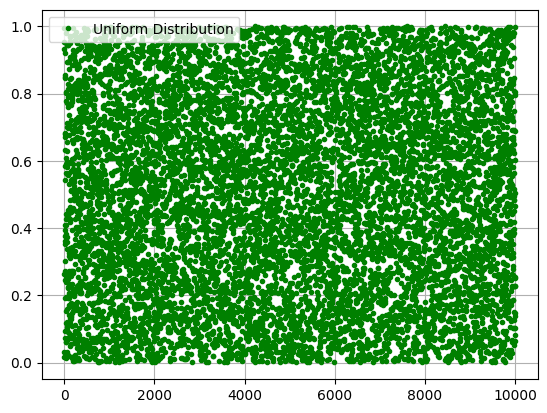

In [15]:
from matplotlib import pyplot as plt
x = np.random.rand(10000) # 每个的概率
t = np.arange(len(x))
plt.plot(t, x, 'g.', label = "Uniform Distribution")
plt.legend(loc = "upper left")
plt.grid()
plt.show()